In [161]:
# import libraries
import os
import sys
import importlib
import geopandas as gpd
import matplotlib.pyplot as plt
from dotenv import dotenv_values
import rasterio as rio
import rioxarray as rxr
from shapely.geometry import mapping
import earthpy as et
import earthpy.plot as ep

%matplotlib inline

# load Landsat8_API_Accessor
sys.path.append('/Users/chasedawson/dev/landsat8_api') # change given where it is run

import landsat8_api
importlib.reload(landsat8_api)
from landsat8_api import Landsat8_API_Accessor

# remove module path from path
sys.path.pop()
    
# print current working directory
os.getcwd()

'/Users/chasedawson/dev/uva_equity_center/summer-sandbox/landsat8'

In [168]:
# read in cville spatial data 
cville_sp = {}
for sp in ['counties', 'tracts', 'blkgps', 'blocks']:
    gdf = gpd.read_file('../spatial_units/data/cville_{sp}.shp'.format(sp = sp))
    cville_sp[sp] = gdf

In [169]:
config = dotenv_values('.env')

In [170]:
accessor = Landsat8_API_Accessor(config['USGS_USERNAME'], config['USGS_PASSWORD'])

Login Successful


In [171]:
SEARCH_START = "2013-06-00"
SEARCH_END = "2021-08-31"

In [172]:
cville = cville_sp['counties'].dissolve()

<AxesSubplot:>

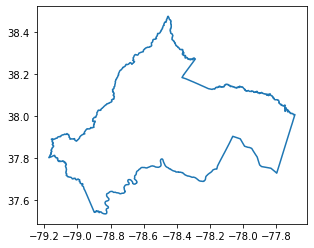

In [173]:
cville.boundary.plot()

In [174]:
res = accessor.get_surface_temperature_data(cville, (SEARCH_START, SEARCH_END), max_results = 50)

Preparing 18 downloads.
3 downloads are not available yet. Waiting for 30s to retrieve again.
Downloaded LC08_L2SP_015033_20170822_20200903_02_T1_ST_B10.TIF.
Downloaded LC08_L2SP_015033_20190727_20200827_02_T1_ST_B10.TIF.
Downloaded LC08_L2SP_015033_20170923_20200903_02_T1_ST_B10.TIF.
Downloaded LC08_L2SP_015033_20190812_20200827_02_T1_ST_B10.TIF.
Downloaded LC08_L2SP_015033_20180708_20200831_02_T1_ST_B10.TIF.
Downloaded LC08_L2SP_015034_20170907_20200903_02_T1_ST_B10.TIF.
Downloaded LC08_L2SP_015034_20170923_20200903_02_T1_ST_B10.TIF.
Downloaded LC08_L2SP_015034_20170822_20200903_02_T1_ST_B10.TIF.
Downloaded LC08_L2SP_015033_20190929_20200825_02_T1_ST_B10.TIF.
Downloaded LC08_L2SP_015034_20180708_20200831_02_T1_ST_B10.TIF.
Downloaded LC08_L2SP_015034_20180926_20200830_02_T1_ST_B10.TIF.
Downloaded LC08_L2SP_015034_20190812_20200827_02_T1_ST_B10.TIF.
Downloaded LC08_L2SP_015034_20190727_20200827_02_T1_ST_B10.TIF.
Downloaded LC08_L2SP_016033_20170813_20200903_02_T1_ST_B10.TIF.
Downloaded

/Users/chasedawson/dev/landsat8_api/landsat8_api.py:475: FutureWarning: Assigning CRS to a GeoDataFrame without a geometry column is now deprecated and will not be supported in the future.
  


In [175]:
res.to_csv('metadata.csv')

In [176]:
os.getcwd()

'/Users/chasedawson/dev/uva_equity_center/summer-sandbox/landsat8'

In [122]:
relative_path_to_data_folder = "./st_b10_data"
relative_path_to_metadata = "./metadata.csv"

In [123]:
import glob

tif_files = glob.glob(relative_path_to_data_folder + "/*.TIF")

In [125]:
def clip_rasters(files, boundary):
    """
    Clip set of rasters given shapefiles. Saves these files in
    'landsat8_c2_l2_data/basename/clipped'. With the geographic region and
    spatial resolution encoded in the name.
    
    Parameters
    ----------
    files : list, required
        List of raster file base names to be clipped.
    
    shp_data : dict, required
        Geometry data for given region. A dictionary containing geometries for different spatial resolutions.
        
    basename : str, required
        Name of geographic region. Either 'cville' or 'easternShore'.
    """
    for path in files:
        with rio.open(path) as src:
            boundary = boundary.to_crs(src.crs)
        raster_data = rxr.open_rasterio(path, masked=True).squeeze()
        raster_clipped = raster_data.rio.clip(boundary.geometry.apply(mapping), boundary.crs)
        # export clipped raster
        raster_clipped.rio.to_raster(path)

In [126]:
clip_rasters(tif_files, cville)

In [136]:
from rasterstats import zonal_stats
import pandas as pd

def my_masked_count(x):
    return np.ma.count_masked(x)

# read in clipped files
# stats notes
# count is the non_masked count
# masked values can be nodata or otherwise masked
def compute_zonal_stats(files, shp_data):
    stats = pd.DataFrame()
    for path in files:
        with rio.open(path) as src:
            affine = src.transform
            nodata = src.profile['nodata']
            raster_data = src.read(1)
            for key in shp_data:
                gdf = shp_data[key]
                gdf = gdf.to_crs(src.crs)
                for i in range(len(gdf)):
                    geoId = gdf.iloc[i].GEOID
                    geom_data = gdf[gdf.GEOID == geoId]
                    geom_stats = pd.DataFrame(zonal_stats(geom_data, raster_data, affine=affine, stats = ['min','max','median','mean','nodata','count'], add_stats={'masked_count': my_masked_count}, nodata=nodata))
                    geom_stats['spatial_unit'] = key
                    geom_stats['GEOID'] = geoId
                    geom_stats['full_path'] = path
                    stats = pd.concat([stats, geom_stats])
    return stats

In [131]:
cville_shp = {k: cville_sp[k][cville_sp[k].COUNTYFP == "540"] for k in cville_sp}

In [137]:
zstats = compute_zonal_stats(tif_files, cville_shp)

/Users/chasedawson/opt/anaconda3/envs/earth-analytics-python/lib/python3.8/site-packages/rasterstats/main.py:260: UserWarning: Warning: converting a masked element to nan.
  feature_stats['nodata'] = float((featmasked == fsrc.nodata).sum())


In [139]:
def prop_nodata(nodata, count):
    if nodata == 0 and count == 0:
        return 0
    else:
        return (nodata / (nodata + count))
    
def rescale(stats):
    MULTIPLICATIVE_SCALE_FACTOR = 0.00341802
    ADDITIVE_SCALE_FACTOR = 149
    cols_to_rescale = ["min", "max", "mean", "median"]
    for col in cols_to_rescale:
        stats[col] = stats[col].apply(lambda x: x * MULTIPLICATIVE_SCALE_FACTOR + ADDITIVE_SCALE_FACTOR if type(x) is float else x)
        stats[col] = stats[col].apply(lambda x: to_fahrenheit(x) if type(x) is float else x)
    return stats

def to_fahrenheit(k):
    return (k - 273.15) * (9/5) + 32

In [140]:
zstats['prop_nodata'] = zstats.apply(lambda x: prop_nodata(x['nodata'], x['count']), axis=1)
zstats = rescale(zstats)

In [142]:
res['file'] = res['displayId'].apply(lambda x: x + "_ST_B10")

In [147]:
zstats['file'] = zstats['full_path'].apply(lambda x: x.split('/')[-1].split('.')[0])

In [148]:
zstats.head()

,min,max,mean,count,median,nodata,masked_count,spatial_unit,GEOID,full_path,prop_nodata,file
0,78.480434,120.255475,91.104427,29557,90.360788,0.0,21968,counties,51540,./st_b10_data/LC08_L2SP_016034_20200906_202009...,0.0,LC08_L2SP_016034_20200906_20200918_02_T1_ST_B10
0,83.519279,108.676590,95.638210,2419,95.651883,0.0,3170,tracts,51540001000,./st_b10_data/LC08_L2SP_016034_20200906_202009...,0.0,LC08_L2SP_016034_20200906_20200918_02_T1_ST_B10
0,84.878968,103.336276,92.728133,1342,91.852754,0.0,1258,tracts,51540000201,./st_b10_data/LC08_L2SP_016034_20200906_202009...,0.0,LC08_L2SP_016034_20200906_20200918_02_T1_ST_B10
0,79.667855,107.642981,87.680253,3420,87.109226,0.0,2180,tracts,51540000502,./st_b10_data/LC08_L2SP_016034_20200906_202009...,0.0,LC08_L2SP_016034_20200906_20200918_02_T1_ST_B10
0,88.958033,106.006433,97.938298,1074,97.552986,0.0,915,tracts,51540000202,./st_b10_data/LC08_L2SP_016034_20200906_202009...,0.0,LC08_L2SP_016034_20200906_20200918_02_T1_ST_B10


In [149]:
res.head()

,file_entityId,scene_entityId,displayId,spatialCoverage,spatialBounds,Date Acquired,Start Time,Stop Time,Day/Night Indicator,Land Cloud Cover,Sun Elevation L0RA,Sun Azimuth L0RA,Datum,file
0,L2ST_LC08_L2SP_016034_20170610_20201015_02_T1_...,LC80160342017161LGN00,LC08_L2SP_016034_20170610_20201015_02_T1,"[[-80.14113, 36.80685], [-78.06613, 36.40817],...","[[-80.14113, 36.40817], [-80.14113, 38.52672],...",2017/06/10,2017:161:15:52:26.4081780,2017:161:15:52:58.1781760,DAY,0.44,67.22683740,123.46389502,WGS84,LC08_L2SP_016034_20170610_20201015_02_T1_ST_B10
1,L2ST_LC08_L2SP_016034_20170930_20200903_02_T1_...,LC80160342017273LGN00,LC08_L2SP_016034_20170930_20200903_02_T1,"[[-80.15024, 36.80627], [-78.07497, 36.40789],...","[[-80.15024, 36.40789], [-80.15024, 38.52615],...",2017/09/30,2017:273:15:52:59.7452590,2017:273:15:53:31.5152570,DAY,0.60,46.16664442,153.53336883,WGS84,LC08_L2SP_016034_20170930_20200903_02_T1_ST_B10
2,L2ST_LC08_L2SP_016034_20160826_20200906_02_T1_...,LC80160342016239LGN01,LC08_L2SP_016034_20160826_20200906_02_T1,"[[-80.13243, 36.80668], [-78.05731, 36.40816],...","[[-80.13243, 36.40816], [-80.13243, 38.52659],...",2016/08/26,2016:239:15:52:54.9667980,2016:239:15:53:26.7367950,DAY,4.82,56.76345427,140.05471917,WGS84,LC08_L2SP_016034_20160826_20200906_02_T1_ST_B10
3,L2ST_LC08_L2SP_016034_20190702_20200827_02_T1_...,LC80160342019183LGN00,LC08_L2SP_016034_20190702_20200827_02_T1,"[[-80.13751, 36.80656], [-78.06257, 36.40787],...","[[-80.13751, 36.40787], [-80.13751, 38.52649],...",2019/07/02,2019:183:15:52:40.4039770,2019:183:15:53:12.1739760,DAY,3.64,66.48453325,121.79135134,WGS84,LC08_L2SP_016034_20190702_20200827_02_T1_ST_B10
4,L2ST_LC08_L2SP_016034_20190920_20200826_02_T1_...,LC80160342019263LGN00,LC08_L2SP_016034_20190920_20200826_02_T1,"[[-80.13634, 36.80638], [-78.06078, 36.40788],...","[[-80.13634, 36.40788], [-80.13634, 38.52616],...",2019/09/20,2019:263:15:53:04.1982720,2019:263:15:53:35.9682710,DAY,0.01,49.62696220,150.05546859,WGS84,LC08_L2SP_016034_20190920_20200826_02_T1_ST_B10


In [150]:
data = zstats.set_index('file').join(res.set_index('file'), on="file")
data.head()

,min,max,mean,count,median,nodata,masked_count,spatial_unit,GEOID,full_path,...,spatialCoverage,spatialBounds,Date Acquired,Start Time,Stop Time,Day/Night Indicator,Land Cloud Cover,Sun Elevation L0RA,Sun Azimuth L0RA,Datum
file,,,,,,,,,,,,,,,,,,,,,
LC08_L2SP_016034_20200906_20200918_02_T1_ST_B10,78.480434,120.255475,91.104427,29557,90.360788,0.0,21968,counties,51540,./st_b10_data/LC08_L2SP_016034_20200906_202009...,...,"[[-80.13726, 36.80658], [-78.06168, 36.40795],...","[[-80.13726, 36.40795], [-80.13726, 38.52635],...",2020/09/06,2020:250:15:52:57.4650050,2020:250:15:53:29.2350040,DAY,0.09,53.69279618,144.81285063,WGS84
LC08_L2SP_016034_20200906_20200918_02_T1_ST_B10,83.519279,108.676590,95.638210,2419,95.651883,0.0,3170,tracts,51540001000,./st_b10_data/LC08_L2SP_016034_20200906_202009...,...,"[[-80.13726, 36.80658], [-78.06168, 36.40795],...","[[-80.13726, 36.40795], [-80.13726, 38.52635],...",2020/09/06,2020:250:15:52:57.4650050,2020:250:15:53:29.2350040,DAY,0.09,53.69279618,144.81285063,WGS84
LC08_L2SP_016034_20200906_20200918_02_T1_ST_B10,84.878968,103.336276,92.728133,1342,91.852754,0.0,1258,tracts,51540000201,./st_b10_data/LC08_L2SP_016034_20200906_202009...,...,"[[-80.13726, 36.80658], [-78.06168, 36.40795],...","[[-80.13726, 36.40795], [-80.13726, 38.52635],...",2020/09/06,2020:250:15:52:57.4650050,2020:250:15:53:29.2350040,DAY,0.09,53.69279618,144.81285063,WGS84
LC08_L2SP_016034_20200906_20200918_02_T1_ST_B10,79.667855,107.642981,87.680253,3420,87.109226,0.0,2180,tracts,51540000502,./st_b10_data/LC08_L2SP_016034_20200906_202009...,...,"[[-80.13726, 36.80658], [-78.06168, 36.40795],...","[[-80.13726, 36.40795], [-80.13726, 38.52635],...",2020/09/06,2020:250:15:52:57.4650050,2020:250:15:53:29.2350040,DAY,0.09,53.69279618,144.81285063,WGS84
LC08_L2SP_016034_20200906_20200918_02_T1_ST_B10,88.958033,106.006433,97.938298,1074,97.552986,0.0,915,tracts,51540000202,./st_b10_data/LC08_L2SP_016034_20200906_202009...,...,"[[-80.13726, 36.80658], [-78.06168, 36.40795],...","[[-80.13726, 36.40795], [-80.13726, 38.52635],...",2020/09/06,2020:250:15:52:57.4650050,2020:250:15:53:29.2350040,DAY,0.09,53.69279618,144.81285063,WGS84


In [155]:
data.GEOID = data.GEOID.apply(lambda x: str(x))

In [158]:
data.GEOID.iloc[10]

'51540000700'

In [159]:
data.to_csv('landsat8_cville_city.csv')

In [160]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 22178 entries, LC08_L2SP_016034_20200906_20200918_02_T1_ST_B10 to LC08_L2SP_016034_20190702_20200827_02_T1_ST_B10
Data columns (total 24 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   min                  21741 non-null  float64
 1   max                  21741 non-null  float64
 2   mean                 21741 non-null  float64
 3   count                22178 non-null  int64  
 4   median               21741 non-null  float64
 5   nodata               21814 non-null  float64
 6   masked_count         22178 non-null  int64  
 7   spatial_unit         22178 non-null  object 
 8   GEOID                22178 non-null  object 
 9   full_path            22178 non-null  object 
 10  prop_nodata          21814 non-null  float64
 11  file_entityId        22178 non-null  object 
 12  scene_entityId       22178 non-null  object 
 13  displayId            22178 non-null  object 
 14  spa

In [178]:
data = pd.read_csv('landsat8_cville_city_v2.csv')
data.head()

,file,min,max,mean,count,median,nodata,masked_count,spatial_unit,GEOID,...,spatialCoverage,spatialBounds,Date Acquired,Start Time,Stop Time,Day/Night Indicator,Land Cloud Cover,Sun Elevation L0RA,Sun Azimuth L0RA,Datum
0,LC08_L2SP_016034_20200906_20200918_02_T1_ST_B10,78.480434,120.255475,91.104427,29557,90.360788,0.0,21968,counties,51540,...,"[[-80.13726, 36.80658], [-78.06168, 36.40795],...","[[-80.13726, 36.40795], [-80.13726, 38.52635],...",2020/09/06,2020:250:15:52:57.4650050,2020:250:15:53:29.2350040,DAY,0.09,53.692796,144.812851,WGS84
1,LC08_L2SP_016034_20200906_20200918_02_T1_ST_B10,83.519279,108.676590,95.638210,2419,95.651883,0.0,3170,tracts,51540001000,...,"[[-80.13726, 36.80658], [-78.06168, 36.40795],...","[[-80.13726, 36.40795], [-80.13726, 38.52635],...",2020/09/06,2020:250:15:52:57.4650050,2020:250:15:53:29.2350040,DAY,0.09,53.692796,144.812851,WGS84
2,LC08_L2SP_016034_20200906_20200918_02_T1_ST_B10,84.878968,103.336276,92.728133,1342,91.852754,0.0,1258,tracts,51540000201,...,"[[-80.13726, 36.80658], [-78.06168, 36.40795],...","[[-80.13726, 36.40795], [-80.13726, 38.52635],...",2020/09/06,2020:250:15:52:57.4650050,2020:250:15:53:29.2350040,DAY,0.09,53.692796,144.812851,WGS84
3,LC08_L2SP_016034_20200906_20200918_02_T1_ST_B10,79.667855,107.642981,87.680253,3420,87.109226,0.0,2180,tracts,51540000502,...,"[[-80.13726, 36.80658], [-78.06168, 36.40795],...","[[-80.13726, 36.40795], [-80.13726, 38.52635],...",2020/09/06,2020:250:15:52:57.4650050,2020:250:15:53:29.2350040,DAY,0.09,53.692796,144.812851,WGS84
4,LC08_L2SP_016034_20200906_20200918_02_T1_ST_B10,88.958033,106.006433,97.938298,1074,97.552986,0.0,915,tracts,51540000202,...,"[[-80.13726, 36.80658], [-78.06168, 36.40795],...","[[-80.13726, 36.40795], [-80.13726, 38.52635],...",2020/09/06,2020:250:15:52:57.4650050,2020:250:15:53:29.2350040,DAY,0.09,53.692796,144.812851,WGS84


In [179]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22178 entries, 0 to 22177
Data columns (total 25 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   file                 22178 non-null  object 
 1   min                  21741 non-null  float64
 2   max                  21741 non-null  float64
 3   mean                 21741 non-null  float64
 4   count                22178 non-null  int64  
 5   median               21741 non-null  float64
 6   nodata               21814 non-null  float64
 7   masked_count         22178 non-null  int64  
 8   spatial_unit         22178 non-null  object 
 9   GEOID                22178 non-null  int64  
 10  full_path            22178 non-null  object 
 11  prop_nodata          21814 non-null  float64
 12  file_entityId        22178 non-null  object 
 13  scene_entityId       22178 non-null  object 
 14  displayId            22178 non-null  object 
 15  spatialCoverage      22178 non-null 

In [180]:
for key in ['counties', 'tracts', 'blkgps', 'blocks']:
    data[data.spatial_unit == key].to_csv('landsat8_cville_city_{key}.csv'.format(key = key))